# Mean-Variance Portfolios with Constraints


In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd

In [2]:
stock_df = pd.read_csv(
    R"D:\Study\Spring 25\Optimization Modeling in Finance\Data\returns_299.csv"
)

In [3]:
cov_panel = pd.read_parquet(
    R"D:\Study\Spring 25\Optimization Modeling in Finance\Project\ORIE-5370-Project-master\daily_covariance_matrix.parquet"
)

In [4]:
returns_df = stock_df.pivot(index="date", columns="PERMNO", values="RET")
returns_df = np.log(returns_df + 1)
returns_df.index = pd.to_datetime(returns_df.index)
monthly_returns_values = returns_df.resample("ME").sum()
month_end_dates = (
    returns_df.index.to_series().groupby(returns_df.index.to_period("M")).last()
)
monthly_returns_df = monthly_returns_values.copy()
monthly_returns_df.index = month_end_dates.values

# Step 2: Equal-weighted portfolio
equal_weights = (
    monthly_returns_df.notna()
    .astype(float)
    .div(monthly_returns_df.notna().sum(axis=1), axis=0)
)
equal_returns = (monthly_returns_df.shift(-1) * equal_weights).sum(axis=1)

In [5]:
dates = cov_panel.index.get_level_values(0)
dates = pd.to_datetime(dates)
month_end_dates = dates.to_series().groupby(dates.to_period("M")).last()

# 2. 过滤 cov_panel，只保留这些日期
cov_panel_monthly = cov_panel.loc[
    pd.to_datetime(cov_panel.index.get_level_values(0)).isin(month_end_dates.values)
]

In [6]:
cov_panel_monthly

10104     10107     10138     10145     10516  \
date       permno_i                                                     
2011-01-31 10104     0.050230  0.033779  0.042546  0.035227  0.047445   
           10107     0.033779  0.043995  0.039818  0.032969  0.044403   
           10138     0.042546  0.039818  0.069798  0.041526  0.055928   
           10145     0.035227  0.032969  0.041526  0.047851  0.046307   
           10516     0.047445  0.044403  0.055928  0.046307  0.086797   
...                       ...       ...       ...       ...       ...   
2022-12-30 91556     0.038133  0.050974  0.057735  0.036775  0.044454   
           92121     0.047439  0.063414  0.071826  0.045750  0.055304   
           92602     0.024908  0.033296  0.037712  0.024021  0.029037   
           92611     0.035834  0.047902  0.054256  0.034559  0.041775   
           92655     0.030129  0.040275  0.045617  0.029056  0.035124   

                        11308     11404     11600     11618     11674  ...  \
date       permno_i                                                    ...   
2011-01-31 10104     0.025479  0.016874  0.046436  0.045083  0.036000  ...   
           10107     0.023845  0.015793  0.043459  0.042192  0.033692  ...   
           10138     0.030035  0.019892  0.054739  0.053143  0.042437  ...   
           10145     0.024868  0.016470  0.045323  0.044002  0.035137  ...   
           10516     0.033493  0.022182  0.061041  0.059262  0.047323  ...   
...                       ...       ...       ...       ...       ...  ...   
2022-12-30 91556     0.026420  0.032812  0.057612  0.046404  0.031608  ...   
           92121     0.032868  0.040820  0.071673  0.057729  0.039322  ...   
           92602     0.017257  0.021432  0.037631  0.030310  0.020646  ...   
           92611     0.024828  0.030835  0.054140  0.043607  0.029703  ...   
           92655     0.020875  0.025925  0.045520  0.036664  0.024974  ...   

                        90808     90829     90880     90993     91233  \
date       permno_i                                                     
2011-01-31 10104     0.057843  0.071964  0.049139  0.044588  0.051709   
           10107     0.054134  0.067350  0.045988  0.041729  0.048394   
           10138     0.068185  0.084831  0.057925  0.052560  0.060955   
           10145     0.056456  0.070239  0.047961  0.043519  0.050470   
           10516     0.076036  0.094599  0.064594  0.058612  0.067973   
...                       ...       ...       ...       ...       ...   
2022-12-30 91556     0.072539  0.066713  0.043468  0.038741  0.046801   
           92121     0.090242  0.082994  0.054076  0.048196  0.058223   
           92602     0.047381  0.043576  0.028393  0.025305  0.030570   
           92611     0.068167  0.062692  0.040848  0.036407  0.043980   
           92655     0.057314  0.052711  0.034344  0.030610  0.036978   

                        91556     92121     92602     92611     92655  
date       permno_i                                                    
2011-01-31 10104     0.041710  0.050025  0.029427  0.047246  0.041708  
           10107     0.039036  0.046817  0.027540  0.044217  0.039034  
           10138     0.049168  0.058969  0.034688  0.055693  0.049166  
           10145     0.040710  0.048826  0.028721  0.046113  0.040708  
           10516     0.054829  0.065759  0.038682  0.062106  0.054827  
...                       ...       ...       ...       ...       ...  
2022-12-30 91556     0.096648  0.058095  0.030503  0.043884  0.036897  
           92121     0.058095  0.149579  0.037947  0.054594  0.045902  
           92602     0.030503  0.037947  0.041235  0.028664  0.024100  
           92611     0.043884  0.054594  0.028664  0.085350  0.034673  
           92655     0.036897  0.045902  0.024100  0.034673  0.060335  

[43056 rows x 299 columns]

In [7]:
import yfinance as yf

start, end = "2010-12-31", "2022-12-31"

idx = (
    yf.download("^GSPC", start=start, end=end, progress=False)
    .loc[:, ["Close"]]
    .rename(columns={"Close": "idx_price"})
)

idx["idx_ret"] = idx["idx_price"].pct_change()
idx["idx_ret"] = np.log(idx["idx_ret"] + 1)
idx = idx.reset_index()[["Date", "idx_ret"]].rename(columns={"Date": "date"})

idx.dropna(inplace=True)
idx.set_index("date", inplace=True)

YF.download() has changed argument auto_adjust default to True


In [8]:
idx

Price,idx_ret
Ticker,
date,
2011-01-03,0.011251
2011-01-04,-0.001314
2011-01-05,0.004995
2011-01-06,-0.002125
2011-01-07,-0.001846
...,...
2022-12-23,0.005851
2022-12-27,-0.004058


In [9]:
idx_monthly_returns_values = idx.resample("ME").sum()
idx_monthly_returns_df = idx_monthly_returns_values.copy()
idx_monthly_returns_df.index = month_end_dates.values
idx_monthly_returns_df.columns = idx_monthly_returns_df.columns.get_level_values(0)

In [10]:
betas = pd.read_parquet("beta.parquet")
betas_df = betas.pivot(index="date", columns="PERMNO", values="beta")

In [11]:
butterflies = pd.read_parquet("butterfly.parquet").drop_duplicates()
butterflies.loc[:, "PERMNO"] = butterflies["PERMNO"].astype("int64")
butterflies_df = butterflies.pivot(index="date", columns="PERMNO", values="butterfly")

In [12]:
risk_reversals = pd.read_parquet("risk_reversal.parquet").drop_duplicates(
    ["date", "PERMNO"]
)
risk_reversals.loc[:, "PERMNO"] = risk_reversals["PERMNO"].astype("int64")
risk_reversals_df = risk_reversals.pivot(
    index="date", columns="PERMNO", values="risk_reversal"
)

In [13]:
idx = pd.IndexSlice

cutoff = "2018-12-31"

train = cov_panel_monthly.loc[idx[:cutoff, :], :]
test = cov_panel_monthly.loc[idx[cutoff:, :], :]

In [14]:
train_equal = equal_returns[:cutoff]
test_equal = equal_returns[cutoff:]

# Grid Search (Abandoned)


In [ ]:
""" import itertools

import numpy as np
import pandas as pd

# 1) 定义搜索空间
delta_space = [0.1, 0.2, 0.3]
weight_space = np.linspace(0, 1, 6)
weight_grids = [
    (w1, w2, 1 - w1 - w2)
    for w1, w2 in itertools.product(weight_space, weight_space)
    if 0 <= 1 - w1 - w2 <= 1
]

results = []

# 2) 外层：遍历所有 δ 组合
for δ_beta, δ_bf, δ_rr in itertools.product(delta_space, repeat=3):
    # 3) 中层：遍历所有权重组合
    for w_beta, w_bf, w_rr in weight_grids:

        meanvar_returns = []
        meanvar_weights = []

        for date, cov_df in train.groupby(level=0):
            cov_matrix = cov_df.droplevel(0)
            assets = cov_matrix.columns

            # Get valid returns
            month_returns = monthly_returns_df.shift(-1).loc[date, assets].dropna()
            valid_assets = month_returns.index
            cov_matrix = cov_matrix.loc[valid_assets, valid_assets]

            month_betas = betas_df.loc[date, assets]
            q_beta = pd.qcut(month_betas, 10, labels=False)

            month_butterflies = butterflies_df.loc[date, assets]
            q_bf = pd.qcut(month_butterflies, 10, labels=False)

            month_risk_reversals = risk_reversals_df.loc[date, assets]
            q_rr = pd.qcut(month_risk_reversals.abs(), 10, labels=False)

            mu0 = idx_monthly_returns_df.loc[date, "idx_ret"]

            # 5) 按当前 δ，构造 mu_beta/mu_bf/mu_rr
            f_beta = 1 + (q_beta == 9) * δ_beta - (q_beta == 0) * δ_beta
            f_bf = 1 + (q_bf == 0) * δ_bf - (q_bf == 9) * δ_bf
            f_rr = 1 + (q_rr == 0) * δ_rr - (q_rr == 9) * δ_rr

            mu_beta = mu0 * f_beta
            mu_bf = mu0 * f_bf
            mu_rr = mu0 * f_rr

            # 6) 按当前 w，加权合成
            mu_combined = w_beta * mu_beta + w_bf * mu_bf + w_rr * mu_rr
            adjusted_returns = pd.Series(mu_combined, index=month_returns.index)

            if len(valid_assets) < 2:
                meanvar_returns.append(np.nan)
                meanvar_weights.append(np.nan)
                continue

            # Setup optimization
            N = len(valid_assets)
            w = cp.Variable(N)

            # Ensure PSD matrix
            Sigma = cov_matrix.values
            eigvals, eigvecs = np.linalg.eigh(Sigma)
            eigvals_clipped = np.clip(eigvals, a_min=0, a_max=None)
            Sigma_psd = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
            Sigma_cvx = cp.psd_wrap(Sigma_psd)

            mu = adjusted_returns.loc[valid_assets].values
            risk_aversion = 1

            # Build optimization problem directly with matrix (no cp.Parameter)
            objective = cp.Minimize(cp.quad_form(w, Sigma_cvx) - risk_aversion * mu @ w)
            constraints = [cp.sum(w) == 1, w >= 0]
            prob = cp.Problem(objective, constraints)

            try:
                prob.solve(solver=cp.SCS)
                weights = w.value
                port_return = weights @ month_returns.loc[valid_assets].values
                meanvar_returns.append(port_return)
                meanvar_weights.append(
                    pd.Series(weights, index=valid_assets, name=date)
                )
            except Exception as e:
                print(f"Optimization failed on {date}: {e}")
                meanvar_returns.append(np.nan)
                meanvar_weights.append(np.nan)

        train_equal.name = "equal_weighted"
        returns_combined = pd.concat(
            [
                train_equal[:-1],
                pd.Series(
                    meanvar_returns[:-1], index=train_equal[:-1].index, name="meanvar"
                ),
            ],
            axis=1,
        )

        equal_ret = returns_combined["equal_weighted"]
        meanvar_ret = returns_combined["meanvar"]

        def compute_metrics(ret_series):
            mean_monthly = ret_series.mean()
            std_monthly = ret_series.std()
            cum_return = ret_series.sum()
            ann_return = mean_monthly * 12
            ann_vol = std_monthly * np.sqrt(12)
            sharpe = ann_return / ann_vol
            return cum_return, ann_vol, sharpe

        cum, vol, sharpe = compute_metrics(
            pd.Series(meanvar_ret, index=train_equal.index[:-1])
        )
        win_rate = (pd.Series(meanvar_ret) > train_equal[:-1]).mean()

        weight_series = [w for w in meanvar_weights if isinstance(w, pd.Series)]
        dates = [w.name for w in weight_series]
        w_df = pd.DataFrame(weight_series, index=dates)
        turnover = w_df.diff().abs().sum(axis=1) / 2
        avg_monthly = turnover.mean()
        turnover_annual = avg_monthly * 12

        # 8) 把这组 (δβ,δBF,δRR,wβ,wBF,wRR) 和结果存下来
        results.append(
            {
                "δ_beta": δ_beta,
                "δ_bf": δ_bf,
                "δ_rr": δ_rr,
                "w_beta": w_beta,
                "w_bf": w_bf,
                "w_rr": w_rr,
                "cum_return": cum,
                "ann_vol": vol,
                "sharpe": sharpe,
                "win_rate": win_rate,
                "turnover_annual": turnover_annual,
            }
        )

res_df = pd.DataFrame(results)
# 比如按 sharpe 排序
best = res_df.sort_values("sharpe", ascending=False).iloc[0]

print("All results:")
display(res_df)
print("Best configuration:")
display(best) """

# Random Search


In [ ]:
def backtest_and_compute_sharpe(δ_beta, δ_bf, δ_rr, w_beta, w_bf, w_rr):
    meanvar_returns = []
    meanvar_weights = []

    for date, cov_df in train.groupby(level=0):
        cov_matrix = cov_df.droplevel(0)
        assets = cov_matrix.columns

        # Get valid returns
        month_returns = monthly_returns_df.shift(-1).loc[date, assets].dropna()
        valid_assets = month_returns.index
        cov_matrix = cov_matrix.loc[valid_assets, valid_assets]

        month_betas = betas_df.loc[date, assets]
        q_beta = pd.qcut(month_betas, 10, labels=False)

        month_butterflies = butterflies_df.loc[date, assets]
        q_bf = pd.qcut(month_butterflies, 10, labels=False)

        month_risk_reversals = risk_reversals_df.loc[date, assets]
        q_rr = pd.qcut(month_risk_reversals.abs(), 10, labels=False)

        mu0 = idx_monthly_returns_df.loc[date, "idx_ret"]

        # 5) 按当前 δ，构造 mu_beta/mu_bf/mu_rr
        f_beta = 1 + (q_beta == 9) * δ_beta - (q_beta == 0) * δ_beta
        f_bf = 1 + (q_bf == 0) * δ_bf - (q_bf == 9) * δ_bf
        f_rr = 1 + (q_rr == 0) * δ_rr - (q_rr == 9) * δ_rr

        mu_beta = mu0 * f_beta
        mu_bf = mu0 * f_bf
        mu_rr = mu0 * f_rr

        # 6) 按当前 w，加权合成
        mu_combined = w_beta * mu_beta + w_bf * mu_bf + w_rr * mu_rr
        adjusted_returns = pd.Series(mu_combined, index=month_returns.index)

        if len(valid_assets) < 2:
            meanvar_returns.append(np.nan)
            meanvar_weights.append(np.nan)
            continue

        # Setup optimization
        N = len(valid_assets)
        w = cp.Variable(N)

        # Ensure PSD matrix
        Sigma = cov_matrix.values
        eigvals, eigvecs = np.linalg.eigh(Sigma)
        eigvals_clipped = np.clip(eigvals, a_min=0, a_max=None)
        Sigma_psd = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
        Sigma_cvx = cp.psd_wrap(Sigma_psd)

        mu = adjusted_returns.loc[valid_assets].values
        risk_aversion = 1

        # Build optimization problem directly with matrix (no cp.Parameter)
        objective = cp.Minimize(cp.quad_form(w, Sigma_cvx) - risk_aversion * mu @ w)
        constraints = [cp.sum(w) == 1, w >= 0]
        prob = cp.Problem(objective, constraints)

        try:
            prob.solve(solver=cp.SCS)
            weights = w.value
            port_return = weights @ month_returns.loc[valid_assets].values
            meanvar_returns.append(port_return)
            meanvar_weights.append(pd.Series(weights, index=valid_assets, name=date))
        except Exception as e:
            print(f"Optimization failed on {date}: {e}")
            meanvar_returns.append(np.nan)
            meanvar_weights.append(np.nan)

    train_equal.name = "equal_weighted"
    returns_combined = pd.concat(
        [
            train_equal[:-1],
            pd.Series(
                meanvar_returns[:-1], index=train_equal[:-1].index, name="meanvar"
            ),
        ],
        axis=1,
    )

    equal_ret = returns_combined["equal_weighted"]
    meanvar_ret = returns_combined["meanvar"]

    def compute_metrics(ret_series):
        mean_monthly = ret_series.mean()
        std_monthly = ret_series.std()
        cum_return = ret_series.sum()
        ann_return = mean_monthly * 12
        ann_vol = std_monthly * np.sqrt(12)
        sharpe = ann_return / ann_vol
        return cum_return, ann_vol, sharpe

    cum, vol, sharpe = compute_metrics(
        pd.Series(meanvar_ret, index=train_equal.index[:-1])
    )

    return sharpe

In [ ]:
import optuna


def objective(trial):
    # 1) 建议样本 δ 和 权重 的取值范围
    δ_beta = trial.suggest_float("δ_beta", 0.1, 0.5, step=0.1)
    δ_bf = trial.suggest_float("δ_bf", 0.1, 0.5, step=0.1)
    δ_rr = trial.suggest_float("δ_rr", 0.1, 0.5, step=0.1)

    w_beta = trial.suggest_float("w_beta", 0.1, 1.0)
    w_bf = trial.suggest_float("w_bf", 0.1, 1.0)
    w_rr = 1.0 - w_beta - w_bf

    if w_rr < 0.099 or w_rr > 1.01:
        raise optuna.exceptions.TrialPruned()

    # 2) 用 δ、w 去回测（同之前逻辑），得到 Sharpe
    sharpe = backtest_and_compute_sharpe(
        δ_beta, δ_bf, δ_rr, w_beta, w_bf, w_rr
    )

    # Optuna 默认是求最小化，所以返回 -Sharpe
    return -sharpe


# 建立一个 study，指定要做 100 次 trial
study = optuna.create_study()
study.optimize(objective, n_trials=300)

print("Best parameters:", study.best_params)
print("Best Sharpe:", -study.best_value)

In [20]:
search_result = study.trials_dataframe()

In [19]:
results = []
meanvar_returns = []
meanvar_weights = []

for date, cov_df in test.groupby(level=0):
    cov_matrix = cov_df.droplevel(0)
    assets = cov_matrix.columns

    # Get valid returns
    month_returns = monthly_returns_df.shift(-1).loc[date, assets].dropna()
    valid_assets = month_returns.index
    cov_matrix = cov_matrix.loc[valid_assets, valid_assets]

    month_betas = betas_df.loc[date, assets]
    q_beta = pd.qcut(month_betas, 10, labels=False)

    month_butterflies = butterflies_df.loc[date, assets]
    q_bf = pd.qcut(month_butterflies, 10, labels=False)

    month_risk_reversals = risk_reversals_df.loc[date, assets]
    q_rr = pd.qcut(month_risk_reversals.abs(), 10, labels=False)

    mu0 = idx_monthly_returns_df.loc[date, "idx_ret"]

    δ_beta = 0.5
    δ_bf = 0.5
    δ_rr = 0.4
    w_beta = 0.2
    w_bf = 0.7
    w_rr = 0.1

    # 5) 按当前 δ，构造 mu_beta/mu_bf/mu_rr
    f_beta = 1 + (q_beta == 9) * δ_beta - (q_beta == 0) * δ_beta
    f_bf = 1 + (q_bf == 0) * δ_bf - (q_bf == 9) * δ_bf
    f_rr = 1 + (q_rr == 0) * δ_rr - (q_rr == 9) * δ_rr

    mu_beta = mu0 * f_beta
    mu_bf = mu0 * f_bf
    mu_rr = mu0 * f_rr

    # 6) 按当前 w，加权合成
    mu_combined = w_beta * mu_beta + w_bf * mu_bf + w_rr * mu_rr
    adjusted_returns = pd.Series(mu_combined, index=month_returns.index)

    if len(valid_assets) < 2:
        meanvar_returns.append(np.nan)
        meanvar_weights.append(np.nan)
        continue

    # Setup optimization
    N = len(valid_assets)
    w = cp.Variable(N)

    # Ensure PSD matrix
    Sigma = cov_matrix.values
    eigvals, eigvecs = np.linalg.eigh(Sigma)
    eigvals_clipped = np.clip(eigvals, a_min=0, a_max=None)
    Sigma_psd = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
    Sigma_cvx = cp.psd_wrap(Sigma_psd)

    mu = adjusted_returns.loc[valid_assets].values
    risk_aversion = 1

    # Build optimization problem directly with matrix (no cp.Parameter)
    objective = cp.Minimize(cp.quad_form(w, Sigma_cvx) - risk_aversion * mu @ w)
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.SCS)
        weights = w.value
        port_return = weights @ month_returns.loc[valid_assets].values
        meanvar_returns.append(port_return)
        meanvar_weights.append(pd.Series(weights, index=valid_assets, name=date))
    except Exception as e:
        print(f"Optimization failed on {date}: {e}")
        meanvar_returns.append(np.nan)
        meanvar_weights.append(np.nan)

test_equal.name = "equal_weighted"
returns_combined = pd.concat(
    [
        test_equal[:-1],
        pd.Series(meanvar_returns[:-1], index=test_equal[:-1].index, name="meanvar"),
    ],
    axis=1,
)

equal_ret = returns_combined["equal_weighted"]
meanvar_ret = returns_combined["meanvar"]


def compute_metrics(ret_series):
    mean_monthly = ret_series.mean()
    std_monthly = ret_series.std(ddof=1)
    cum_return = ret_series.sum()
    ann_return = mean_monthly * 12
    ann_vol = std_monthly * np.sqrt(12)
    sharpe = ann_return / ann_vol
    return cum_return, ann_vol, sharpe


cum, vol, sharpe = compute_metrics(pd.Series(meanvar_ret, index=test_equal.index[:-1]))
win_rate = (pd.Series(meanvar_ret) > test_equal[:-1]).mean()

weight_series = [w for w in meanvar_weights if isinstance(w, pd.Series)]
dates = [w.name for w in weight_series]
w_df = pd.DataFrame(weight_series, index=dates)
turnover = w_df.diff().abs().sum(axis=1) / 2
avg_monthly = turnover.mean()
turnover_annual = avg_monthly * 12

results.append(
    {
        "cum_return": cum,
        "ann_vol": vol,
        "sharpe": sharpe,
        "win_rate": win_rate,
        "turnover_annual": turnover_annual,
    }
)

print("Test results:")
display(pd.DataFrame(results))

Test results:


,cum_return,ann_vol,sharpe,win_rate,turnover_annual
0,0.60803,0.154722,0.982454,0.479167,10.65963


In [17]:
results = []

meanvar_returns = []
meanvar_weights = []

for date, cov_df in cov_panel_monthly.groupby(level=0):
    cov_matrix = cov_df.droplevel(0)
    assets = cov_matrix.columns

    # Get valid returns
    month_returns = monthly_returns_df.shift(-1).loc[date, assets].dropna()
    valid_assets = month_returns.index
    cov_matrix = cov_matrix.loc[valid_assets, valid_assets]

    month_betas = betas_df.loc[date, assets]
    q_beta = pd.qcut(month_betas, 10, labels=False)

    month_butterflies = butterflies_df.loc[date, assets]
    q_bf = pd.qcut(month_butterflies, 10, labels=False)

    month_risk_reversals = risk_reversals_df.loc[date, assets]
    q_rr = pd.qcut(month_risk_reversals.abs(), 10, labels=False)

    mu0 = idx_monthly_returns_df.loc[date, "idx_ret"]

    δ_beta = 0.5
    δ_bf = 0.5
    δ_rr = 0.4
    w_beta = 0.2
    w_bf = 0.7
    w_rr = 0.1

    # 5) 按当前 δ，构造 mu_beta/mu_bf/mu_rr
    f_beta = 1 + (q_beta == 9) * δ_beta - (q_beta == 0) * δ_beta
    f_bf = 1 + (q_bf == 0) * δ_bf - (q_bf == 9) * δ_bf
    f_rr = 1 + (q_rr == 0) * δ_rr - (q_rr == 9) * δ_rr

    mu_beta = mu0 * f_beta
    mu_bf = mu0 * f_bf
    mu_rr = mu0 * f_rr

    # 6) 按当前 w，加权合成
    mu_combined = w_beta * mu_beta + w_bf * mu_bf + w_rr * mu_rr
    adjusted_returns = pd.Series(mu_combined, index=month_returns.index)

    if len(valid_assets) < 2:
        meanvar_returns.append(np.nan)
        meanvar_weights.append(np.nan)
        continue

    # Setup optimization
    N = len(valid_assets)
    w = cp.Variable(N)

    # Ensure PSD matrix
    Sigma = cov_matrix.values
    eigvals, eigvecs = np.linalg.eigh(Sigma)
    eigvals_clipped = np.clip(eigvals, a_min=0, a_max=None)
    Sigma_psd = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
    Sigma_cvx = cp.psd_wrap(Sigma_psd)

    mu = adjusted_returns.loc[valid_assets].values
    risk_aversion = 1

    # Build optimization problem directly with matrix (no cp.Parameter)
    objective = cp.Minimize(cp.quad_form(w, Sigma_cvx) - risk_aversion * mu @ w)
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(objective, constraints)

    try:
        prob.solve(solver=cp.SCS)
        weights = w.value
        port_return = weights @ month_returns.loc[valid_assets].values
        meanvar_returns.append(port_return)
        meanvar_weights.append(pd.Series(weights, index=valid_assets, name=date))
    except Exception as e:
        print(f"Optimization failed on {date}: {e}")
        meanvar_returns.append(np.nan)
        meanvar_weights.append(np.nan)

equal_returns.name = "equal_weighted"
returns_combined = pd.concat(
    [
        equal_returns[:-1],
        pd.Series(meanvar_returns[:-1], index=equal_returns[:-1].index, name="meanvar"),
    ],
    axis=1,
)

equal_ret = returns_combined["equal_weighted"]
meanvar_ret = returns_combined["meanvar"]


def compute_metrics(ret_series):
    mean_monthly = ret_series.mean()
    std_monthly = ret_series.std(ddof=1)
    cum_return = ret_series.sum()
    ann_return = mean_monthly * 12
    ann_vol = std_monthly * np.sqrt(12)
    sharpe = ann_return / ann_vol
    return cum_return, ann_vol, sharpe


mv_cum, mv_vol, mv_sharpe = compute_metrics(meanvar_ret)
wins = meanvar_ret > equal_ret
win_rate = wins.mean()

weight_series = [w for w in meanvar_weights if isinstance(w, pd.Series)]
dates = [w.name for w in weight_series]
w_df = pd.DataFrame(weight_series, index=dates)

turnover = w_df.diff().abs().sum(axis=1) / 2
avg_monthly = turnover.mean()
turnover_annual = avg_monthly * 12

results.append(
    {
        "cum_return": mv_cum,
        "ann_vol": mv_vol,
        "sharpe": mv_sharpe,
        "win_rate": win_rate,
        "turnover_annual": turnover_annual,
    }
)

print("Factor")
display(pd.DataFrame(results))

Factor


,cum_return,ann_vol,sharpe,win_rate,turnover_annual
0,1.769401,0.122075,1.216308,0.517483,10.556811


In [ ]:
import cvxpy as cp
import numpy as np
import pandas as pd

# 1) 设定参数
subsample_size = 150
n_bootstrap = 1000

# 2) 结果存储
results = []
np.random.seed(42)
# 3) Bootstrap 循环
for i in range(n_bootstrap):
    # 随机抽 subsample_size 只股票
    stocks = np.random.choice(
        cov_panel_monthly.columns,
        size=subsample_size,
        replace=False,
    )

    meanvar_returns = []
    meanvar_weights = []

    # 4) 时间循环回测
    for date, cov_df in cov_panel_monthly.groupby(level=0):
        cov_matrix = cov_df.droplevel(0)
        cov_matrix = cov_matrix.loc[stocks, stocks]
        assets = cov_matrix.columns

        # 当月收益
        month_rets = monthly_returns_df.shift(-1).loc[date, assets].dropna()
        valid = month_rets.index
        cov_matrix = cov_matrix.loc[valid, valid]

        # 分位数因子
        month_betas = betas_df.loc[date, assets]
        q_beta = pd.qcut(month_betas, 10, labels=False)

        month_butterflies = butterflies_df.loc[date, assets]
        q_bf = pd.qcut(month_butterflies, 10, labels=False)

        month_risk_reversals = risk_reversals_df.loc[date, assets]
        q_rr = pd.qcut(month_risk_reversals.abs(), 10, labels=False)

        mu0 = idx_monthly_returns_df.loc[date, "idx_ret"]
        δ_beta, δ_bf, δ_rr = 0.5, 0.5, 0.4
        w_beta, w_bf, w_rr = 0.2, 0.7, 0.1

        # 构造调整后收益
        f_beta = 1 + (q_beta == 9) * δ_beta - (q_beta == 0) * δ_beta
        f_bf = 1 + (q_bf == 0) * δ_bf - (q_bf == 9) * δ_bf
        f_rr = 1 + (q_rr == 0) * δ_rr - (q_rr == 9) * δ_rr

        mu_beta = mu0 * f_beta
        mu_bf = mu0 * f_bf
        mu_rr = mu0 * f_rr

        mu_combined = w_beta * mu_beta + w_bf * mu_bf + w_rr * mu_rr
        mu_series = pd.Series(mu_combined, index=valid)

        if len(valid) < 2:
            meanvar_returns.append(np.nan)
            meanvar_weights.append(np.nan)
            continue

        # CVX 最小化
        w = cp.Variable(len(valid))
        Sigma = cov_matrix.values
        eigs, vecs = np.linalg.eigh(Sigma)
        Sigma_psd = vecs @ np.diag(np.clip(eigs, 0, None)) @ vecs.T
        Sigma_cvx = cp.psd_wrap(Sigma_psd)
        obj = cp.Minimize(cp.quad_form(w, Sigma_cvx) - mu_series.values @ w)
        prob = cp.Problem(obj, [cp.sum(w) == 1, w >= 0])
        prob.solve(solver=cp.SCS)

        weights = w.value
        port_ret = weights @ month_rets.loc[valid].values

        meanvar_returns.append(port_ret)
        meanvar_weights.append(pd.Series(weights, index=valid))

    # 5) 统计指标
    equal_returns.name = "equal_weighted"
    returns_combined = pd.concat(
        [
            equal_returns[:-1],
            pd.Series(
                meanvar_returns[:-1], index=equal_returns[:-1].index, name="meanvar"
            ),
        ],
        axis=1,
    )

    meanvar_ret = returns_combined["meanvar"]

    def compute_metrics(ret_series):
        mean_monthly = ret_series.mean()
        std_monthly = ret_series.std(ddof=1)
        cum_return = ret_series.sum()
        ann_return = mean_monthly * 12
        ann_vol = std_monthly * np.sqrt(12)
        sharpe = ann_return / ann_vol
        return cum_return, ann_vol, sharpe

    mv_cum, mv_vol, mv_sharpe = compute_metrics(meanvar_ret)

    weight_series = [w for w in meanvar_weights if isinstance(w, pd.Series)]
    dates = [w.name for w in weight_series]
    w_df = pd.DataFrame(weight_series, index=dates)

    turnover = w_df.diff().abs().sum(axis=1) / 2
    avg_monthly = turnover.mean()
    turnover_annual = avg_monthly * 12

    results.append(
        {
            "bootstrap": i + 1,
            "cum_return": mv_cum,
            "ann_vol": mv_vol,
            "sharpe": mv_sharpe,
            "turnover_annual": turnover_annual,
        }
    )

# 6) 汇总输出
res_df = pd.DataFrame(results).set_index("bootstrap")
display(res_df.head())

,cum_return,ann_vol,sharpe,turnover_annual
bootstrap,,,,
1,1.627441,0.123340,1.107248,10.158606
2,1.550099,0.119217,1.091104,10.013972
3,1.804691,0.126427,1.197870,10.187789
4,1.462911,0.121117,1.013580,9.999422
5,1.622099,0.117636,1.157128,9.987655


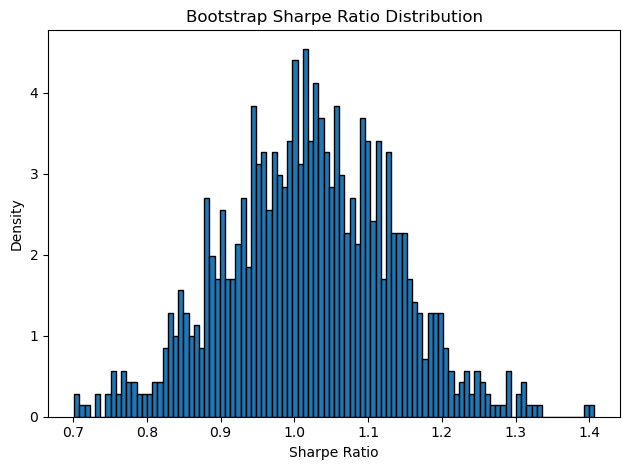

In [45]:
import matplotlib.pyplot as plt

sharpe_vals = res_df["sharpe"]


# 左：直方图
plt.hist(sharpe_vals, bins=100, density=True, edgecolor="black")
plt.title("Bootstrap Sharpe Ratio Distribution")
plt.xlabel("Sharpe Ratio")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

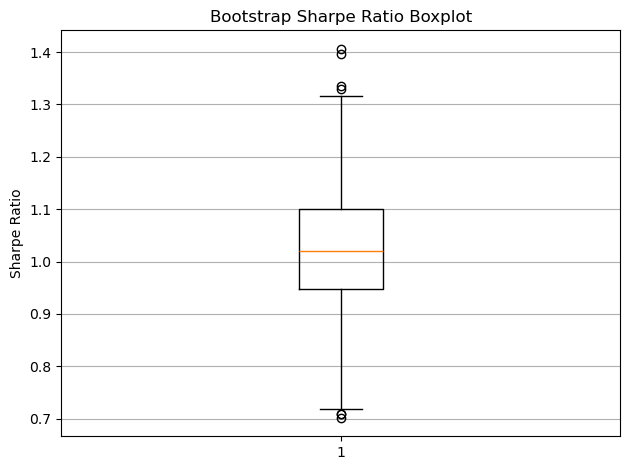

In [37]:
plt.boxplot(sharpe_vals, vert=True)
plt.title("Bootstrap Sharpe Ratio Boxplot")
plt.ylabel("Sharpe Ratio")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

In [32]:
q1 = sharpe_vals.quantile(0.25)
q3 = sharpe_vals.quantile(0.75)
iqr = q3 - q1

lower_whisker = max(sharpe_vals.min(), q1 - 1.5 * iqr)
upper_whisker = min(sharpe_vals.max(), q3 + 1.5 * iqr)

print(f"Q1 = {q1:.3f}")
print(f"Q3 = {q3:.3f}")
print(f"IQR = {iqr:.3f}")
print(f"lower whisker = {lower_whisker:.3f}")
print(f"upper whisker = {upper_whisker:.3f}")

Q1 = 0.947
Q3 = 1.099
IQR = 0.152
lower whisker = 0.718
upper whisker = 1.328


In [33]:
sharpe_vals.quantile(0.025)

np.float64(0.7924809176659611)

In [41]:
from scipy import stats

mean = sharpe_vals.mean()
se = sharpe_vals.std(ddof=1) / np.sqrt(n_bootstrap)
margin = stats.t.ppf(1 - 0.05 / 2, n_bootstrap - 1) * se
print((mean - margin, mean + margin))

(np.float64(1.0130709199919583), np.float64(1.027082612063056))


In [ ]:
# equal_returns.name = 'equal_weighted'
# returns_combined = pd.concat([equal_returns[:-1], pd.Series(meanvar_returns[:-1], index=equal_returns[:-1].index, name='meanvar')], axis=1)
# print(returns_combined)

# equal_ret = returns_combined["equal_weighted"]
# meanvar_ret = returns_combined["meanvar"]


# def compute_metrics(ret_series):
#     mean_monthly = ret_series.mean()
#     std_monthly = ret_series.std()
#     cum_return = ret_series.sum()
#     ann_return = mean_monthly * 12
#     ann_vol = std_monthly * np.sqrt(12)
#     sharpe = ann_return / ann_vol
#     return cum_return, ann_vol, sharpe


# # Compute metrics for both portfolios
# eq_cum, eq_vol, eq_sharpe = compute_metrics(equal_ret)
# mv_cum, mv_vol, mv_sharpe = compute_metrics(meanvar_ret)

# # Build comparison DataFrame
# comparison_df = pd.DataFrame(
#     {
#         "Cumulative Return": [eq_cum, mv_cum],
#         "Annual Volatility": [eq_vol, mv_vol],
#         "Sharpe Ratio": [eq_sharpe, mv_sharpe],
#     },
#     index=["Equal Weighted", "Mean-Var"],
# )

# print(comparison_df)